### Analysis of the resutls

*Authors*
- [José Luis Garrido Labrador](https://orcid.org/0000-0002-3441-4223)
- [Jesús Manuel Maudes Raedo](https://orcid.org/0000-0001-8808-412X)
- [Juan José Rodríguez Diez](https://orcid.org/0000-0002-3291-2739)
- [César Ignacio García Osorio](https://orcid.org/0000-0002-1206-1084)

In [1]:
%matplotlib inline
import dill as pk
import numpy as np
import pandas as pd
import itertools as it
import scipy.stats as stats
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


In [2]:
# Load accuracies and F1 scores
with open('dn_results.pkl', 'rb') as f:
    accuracies = pk.load(f)
with open('dn_f1_results.pkl', 'rb') as f:
    f1_scores = pk.load(f)

In [3]:
map_names = {
    "TriTraining-Bag": "TriBag",
    "Bagging": "Bag",
    "TriTraining-DN-Bag": "TriBagDN",
    "DisturbingNeighbors-Bag": "BagDN",
    "SelfDisturbingNeighbors-Bag": "SelfBagDN",
    "Self-Bag": "SelfBag",
    "CoTrainingByCommittee-Bag": "CTCBag",
    "CoTrainingByCommittee-DisturbingNeighbors-Bag": "CTCBagDN"
}

alpha = 0.05

In [4]:
acc10 = accuracies["trans_acc_10"]
acc20 = accuracies["trans_acc_20"]
acc30 = accuracies["trans_acc_30"]
acc40 = accuracies["trans_acc_40"]

f110 = f1_scores["trans_fm_10"]
f120 = f1_scores["trans_fm_20"]
f130 = f1_scores["trans_fm_30"]
f140 = f1_scores["trans_fm_40"]

acc10i = accuracies["ind_acc_10"]
acc20i = accuracies["ind_acc_20"]
acc30i = accuracies["ind_acc_30"]
acc40i = accuracies["ind_acc_40"]

f110i = f1_scores["ind_fm_10"]
f120i = f1_scores["ind_fm_20"]
f130i = f1_scores["ind_fm_30"]
f140i = f1_scores["ind_fm_40"]

In [5]:
def _calc_numpy_results(results, method):
    results = results.copy()
    
    # Transform all values in a list
    results[method] = np.array(list(results[method].values()))

    return results

def _calc_mean_by_method(results, method):
    return results[method].mean(axis=1)

def _calc_all_means(results):
    means = dict()
    for method in results:
        means[method] = _calc_mean_by_method(_calc_numpy_results(results, method), method).mean()
    return means

def stats_test(results, pair="all", kind="ttest"):
    if pair == "all":
        pair = list(it.combinations(results.keys(), 2))

    results = results.copy()
    means = dict()
    # Calculate the mean of each method

    for method in results:
        results = _calc_numpy_results(results, method)
        means[method] = _calc_mean_by_method(results, method).tolist()

    names = dict()

    for p1, p2 in pair:
        if kind == "ttest":
            _, p = stats.ttest_rel(results[p1], results[p2])
        elif kind == "wilcoxon":
            _, p = stats.wilcoxon(results[p1].flatten(), results[p2].flatten())
        else:
            raise ValueError(f"Kind `{kind}` not supported, use ttest or wilcoxon")
        diff = np.mean(np.array(means[p1]) - np.array(means[p2]))
        
        
        names[(p1, p2)] = (p, diff)
    return names

def ranking(test_results, alpha=0.05):
        
    results = defaultdict(int)
    draws = defaultdict(int)

    for p1, p2 in test_results:
        for i in range(len(test_results[(p1, p2)][0])):
            if test_results[(p1, p2)][0][i] < alpha:
                if test_results[(p1, p2)][1][i] == 1:
                    results[p1] += 1
                elif test_results[(p1, p2)][1][i] == -1:
                    results[p2] += 1
            else:
                draws[p1] += 1
                draws[p2] += 1

    return results, draws

def wilcoxon_rank_df(wilcoxon_results, percent=10, alpha=0.05):

    models = set()
    for m1, m2 in wilcoxon_results.keys():
        models.add(m1)
        models.add(m2)
    models = list(models)

    dataframe = pd.DataFrame(index=models, columns=pd.MultiIndex.from_product([[percent], ["+", "±"]]))
    dataframe = dataframe.fillna(0)
    for m1, m2 in wilcoxon_results.keys():
        p_value = wilcoxon_results[(m1, m2)][0]
        diff = wilcoxon_results[(m1, m2)][1]
        if diff > 0:
            winner = m1
        else:
            winner = m2
        if p_value < alpha:
            dataframe.loc[winner, (percent, "+")] += 1
            dataframe.loc[winner, (percent, "±")] += 1
        if p_value >= alpha:
            dataframe.loc[m1, (percent, "±")] += 1
            dataframe.loc[m2, (percent, "±")] += 1
    
    return dataframe.astype(int)

In [6]:
def create_df_of_means(acc, f1):
    # Means of all methods accuracies and F1 scores
    means_acc = _calc_all_means(acc)
    means_f1 = _calc_all_means(f1)
    # Create a DF joining the means of accuracies and F1 scores
    df = pd.DataFrame([means_acc, means_f1], index=["Accuracy", "F1"]).T
    # Format the names of the methods
    df.index = df.index.map(map_names)
    # Sort the DF by F1
    df = df.sort_values(by="Accuracy", ascending=False)
    # Format only 4 decimal places
    return df

In [7]:
m10 = create_df_of_means(acc10, f110)
m20 = create_df_of_means(acc20, f120)
m30 = create_df_of_means(acc30, f130)
m40 = create_df_of_means(acc40, f140)
m10i = create_df_of_means(acc10i, f110i)
m20i = create_df_of_means(acc20i, f120i)
m30i = create_df_of_means(acc30i, f130i)
m40i = create_df_of_means(acc40i, f140i)

# Create a DF with the means of all accuracies and F1 scores by percentage and transductive/inductive
means_trans = pd.concat([m10, m20, m30, m40], axis=1, keys=["10%", "20%", "30%", "40%"])
means_ind = pd.concat([m10i, m20i, m30i, m40i], axis=1, keys=["10%", "20%", "30%", "40%"])

means_trans_4decimals = means_trans.applymap(lambda x: f"{x:.4f}")
means_ind_4decimals = means_ind.applymap(lambda x: f"{x:.4f}")
display(means_trans_4decimals)
display(means_ind_4decimals)

10%              20%              30%              40%        
          Accuracy      F1 Accuracy      F1 Accuracy      F1 Accuracy      F1
BagDN       0.7615  0.6683   0.7885  0.7048   0.8050  0.7293   0.8124  0.7402
TriBagDN    0.7566  0.6542   0.7851  0.6944   0.8019  0.7115   0.8136  0.7357
Bag         0.7556  0.6574   0.7841  0.6931   0.7926  0.7110   0.8038  0.7249
CTCBagDN    0.7532  0.6444   0.7832  0.6875   0.7990  0.7121   0.8087  0.7260
TriBag      0.7524  0.6472   0.7824  0.6919   0.7960  0.7106   0.8084  0.7289
CTCBag      0.7473  0.6378   0.7784  0.6865   0.7947  0.7109   0.8082  0.7304
SelfBagDN   0.7389  0.6056   0.7751  0.6678   0.7911  0.6913   0.8056  0.7190
SelfBag     0.7276  0.5998   0.7726  0.6688   0.7909  0.6954   0.8032  0.7144

10%              20%              30%              40%        
          Accuracy      F1 Accuracy      F1 Accuracy      F1 Accuracy      F1
BagDN       0.7629  0.6741   0.7907  0.7111   0.8072  0.7349   0.8159  0.7461
TriBagDN    0.7573  0.6509   0.7840  0.6898   0.8016  0.7056   0.8131  0.7315
Bag         0.7573  0.6633   0.7861  0.6996   0.7949  0.7156   0.8067  0.7295
TriBag      0.7530  0.6443   0.7799  0.6856   0.7921  0.7010   0.8058  0.7206
CTCBagDN    0.7508  0.6359   0.7821  0.6805   0.7975  0.7045   0.8077  0.7170
CTCBag      0.7460  0.6317   0.7751  0.6776   0.7919  0.7010   0.8059  0.7224
SelfBagDN   0.7389  0.6075   0.7763  0.6722   0.7921  0.6941   0.8078  0.7237
SelfBag     0.7272  0.6002   0.7735  0.6727   0.7923  0.6981   0.8055  0.7177

In [8]:
w10 = wilcoxon_rank_df(stats_test(acc10, kind="wilcoxon"), percent=10, alpha=alpha)
w20 = wilcoxon_rank_df(stats_test(acc20, kind="wilcoxon"), percent=20, alpha=alpha)
w30 = wilcoxon_rank_df(stats_test(acc30, kind="wilcoxon"), percent=30, alpha=alpha)
w40 = wilcoxon_rank_df(stats_test(acc40, kind="wilcoxon"), percent=40, alpha=alpha)
df = pd.concat([w10, w20, w30, w40], axis=1).fillna(-1).astype(int).sort_values(by=(10, "+"), ascending=False)
df.index = df.index.map(map_names)

In [9]:
w10i = wilcoxon_rank_df(stats_test(acc10i, kind="wilcoxon"), percent=10, alpha=alpha)
w20i = wilcoxon_rank_df(stats_test(acc20i, kind="wilcoxon"), percent=20, alpha=alpha)
w30i = wilcoxon_rank_df(stats_test(acc30i, kind="wilcoxon"), percent=30, alpha=alpha)
w40i = wilcoxon_rank_df(stats_test(acc40i, kind="wilcoxon"), percent=40, alpha=alpha)
dfi = pd.concat([w10i, w20i, w30i, w40i], axis=1).fillna(-1).astype(int).sort_values(by=(10, "+"), ascending=False)
dfi.index = dfi.index.map(map_names)

In [10]:
w10f = wilcoxon_rank_df(stats_test(f110, kind="wilcoxon"), percent=10, alpha=alpha)
w20f = wilcoxon_rank_df(stats_test(f120, kind="wilcoxon"), percent=20, alpha=alpha)
w30f = wilcoxon_rank_df(stats_test(f130, kind="wilcoxon"), percent=30, alpha=alpha)
w40f = wilcoxon_rank_df(stats_test(f140, kind="wilcoxon"), percent=40, alpha=alpha)
dff = pd.concat([w10f, w20f, w30f, w40f], axis=1).fillna(-1).astype(int).sort_values(by=(10, "+"), ascending=False)
dff.index = dff.index.map(map_names)

In [11]:
w10fi = wilcoxon_rank_df(stats_test(f110i, kind="wilcoxon"), percent=10, alpha=alpha)
w20fi = wilcoxon_rank_df(stats_test(f120i, kind="wilcoxon"), percent=20, alpha=alpha)
w30fi = wilcoxon_rank_df(stats_test(f130i, kind="wilcoxon"), percent=30, alpha=alpha)
w40fi = wilcoxon_rank_df(stats_test(f140i, kind="wilcoxon"), percent=40, alpha=alpha)
dffi = pd.concat([w10fi, w20fi, w30fi, w40fi], axis=1).fillna(-1).astype(int).sort_values(by=(10, "+"), ascending=False)
dffi.index = dffi.index.map(map_names)

In [12]:
# Concat dataframes df and dff
df_trans = pd.concat([df, dff], axis=1, keys=["Acc", "F1"])
df_ind = pd.concat([dfi, dffi], axis=1, keys=["Acc", "F1"])
display(df_trans)
display(df_ind)

Acc                      F1                     
           10    20    30    40    10    20    30    40   
            +  ±  +  ±  +  ±  +  ±  +  ±  +  ±  +  ±  +  ±
BagDN       7  7  7  7  7  7  6  7  7  7  7  7  7  7  7  7
TriBagDN    6  6  6  6  6  6  6  7  5  5  5  6  5  5  6  6
Bag         5  5  4  5  0  2  0  1  6  6  5  6  2  5  1  3
TriBag      3  4  3  3  3  4  3  4  4  4  3  4  2  4  1  4
CTCBagDN    3  4  4  5  5  5  4  5  3  3  3  4  5  6  3  4
CTCBag      2  2  2  2  3  4  2  4  2  2  2  2  2  4  5  5
SelfBagDN   1  1  1  1  0  2  2  4  0  1  0  1  0  1  1  3
SelfBag     0  0  0  0  0  2  0  1  0  1  0  1  0  1  0  0

Acc                      F1                     
           10    20    30    40    10    20    30    40   
            +  ±  +  ±  +  ±  +  ±  +  ±  +  ±  +  ±  +  ±
BagDN       7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
TriBagDN    5  6  5  6  6  6  6  6  5  5  5  5  5  5  6  6
Bag         5  6  5  6  1  4  0  4  6  6  6  6  6  6  5  5
TriBag      3  4  3  3  0  3  0  2  4  4  3  4  0  3  0  2
CTCBagDN    3  4  4  4  5  5  2  5  3  3  3  4  4  4  0  2
CTCBag      2  2  1  2  0  4  2  4  2  2  2  2  0  3  3  3
SelfBagDN   1  1  1  2  0  4  4  5  1  1  0  1  0  3  4  4
SelfBag     0  0  0  0  0  4  0  2  0  0  0  1  0  3  0  2

In [13]:
# Tables of means
means_acc_t = _calc_all_means(acc10)
# Map names
means_acc_t = {map_names[k]: v for k, v in means_acc_t.items()}
means_f1_t = _calc_all_means(f110)
# Map names
means_f1_t = {map_names[k]: v for k, v in means_f1_t.items()}
means_acc_i = _calc_all_means(acc10i)
# Map names
means_acc_i = {map_names[k]: v for k, v in means_acc_i.items()}
means_f1_i = _calc_all_means(f110i)
# Map names
means_f1_i = {map_names[k]: v for k, v in means_f1_i.items()}

# Difference between all agains bagging
diff_acc_t = {k: v - means_acc_t["Bag"] for k, v in means_acc_t.items()}
diff_f1_t = {k: v - means_f1_t["Bag"] for k, v in means_f1_t.items()}
diff_acc_i = {k: v - means_acc_i["Bag"] for k, v in means_acc_i.items()}
diff_f1_i = {k: v - means_f1_i["Bag"] for k, v in means_f1_i.items()}

# Difference between DN and their respective version: TriBagDN vs TriBag, BagDN vs Bag, SelfBagDN vs SelfBag
diff_acc_t_dn = {k: v - means_acc_t[k.replace("DN", "")] for k, v in means_acc_t.items() if "DN" in k}
diff_f1_t_dn = {k: v - means_f1_t[k.replace("DN", "")] for k, v in means_f1_t.items() if "DN" in k}
diff_acc_i_dn = {k: v - means_acc_i[k.replace("DN", "")] for k, v in means_acc_i.items() if "DN" in k}
diff_f1_i_dn = {k: v - means_f1_i[k.replace("DN", "")] for k, v in means_f1_i.items() if "DN" in k}


In [14]:
# Set style
sns.set_style("whitegrid")
# Set palette
sns.set_palette("colorblind")

In [15]:
means_trans[("10%", "Accuracy")]

BagDN        0.761462
TriBagDN     0.756581
Bag          0.755612
CTCBagDN     0.753174
TriBag       0.752428
CTCBag       0.747266
SelfBagDN    0.738890
SelfBag      0.727623
Name: (10%, Accuracy), dtype: float64

In [16]:
# Transform the dataframes to seaborn format
means_transductive = pd.DataFrame(columns=["Metric", "Value", "Method", "Label rate"])
means_inductive = pd.DataFrame(columns=["Metric", "Value", "Method", "Label rate"])
# mean_trans to means_transductive
for (label_rate, metric) in means_trans.columns:
    for method in means_trans.index:
        # Append without the method append
        means_transductive.loc[len(means_transductive)] = {"Metric": metric, "Value": means_trans[(label_rate, metric)][method], "Method": method, "Label rate": label_rate}
        means_inductive.loc[len(means_inductive)] = {"Metric": metric, "Value": means_ind[(label_rate, metric)][method], "Method": method, "Label rate": label_rate}
# Drop the index
means_transductive = means_transductive.reset_index(drop=True)
means_inductive = means_inductive.reset_index(drop=True)
display(means_transductive)
display(means_inductive)

,Metric,Value,Method,Label rate
0,Accuracy,0.761462,BagDN,10%
1,Accuracy,0.756581,TriBagDN,10%
2,Accuracy,0.755612,Bag,10%
3,Accuracy,0.753174,CTCBagDN,10%
4,Accuracy,0.752428,TriBag,10%
...,...,...,...,...
59,F1,0.725968,CTCBagDN,40%
60,F1,0.728921,TriBag,40%
61,F1,0.730389,CTCBag,40%
62,F1,0.718962,SelfBagDN,40%


,Metric,Value,Method,Label rate
0,Accuracy,0.762889,BagDN,10%
1,Accuracy,0.757302,TriBagDN,10%
2,Accuracy,0.757265,Bag,10%
3,Accuracy,0.750783,CTCBagDN,10%
4,Accuracy,0.753045,TriBag,10%
...,...,...,...,...
59,F1,0.716985,CTCBagDN,40%
60,F1,0.720558,TriBag,40%
61,F1,0.722380,CTCBag,40%
62,F1,0.723708,SelfBagDN,40%


In [77]:
cmap = plt.get_cmap('jet')  
colors = [cmap(int(i)) for i in np.linspace(0, 200, 30)]

custom_cmap = ListedColormap(colors)

sns.set_theme(font_scale=1.15, font="Liberation Serif", palette=sns.color_palette("husl", 8), style="whitegrid")

/tmp/ipykernel_157493/2404025207.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["", "", "", ""])
/tmp/ipykernel_157493/2404025207.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18)
/tmp/ipykernel_157493/2404025207.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["", "", "", ""])
/tmp/ipykernel_157493/2404025207.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18)


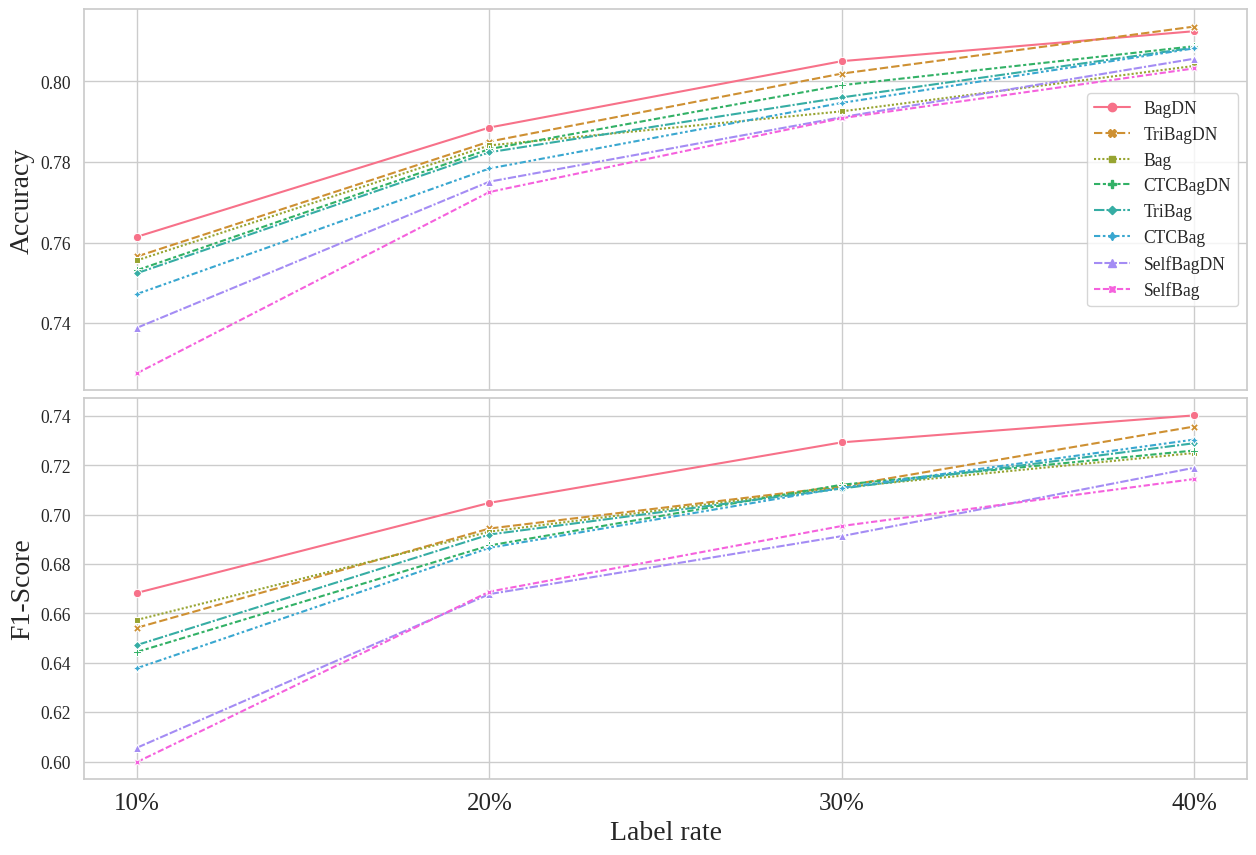

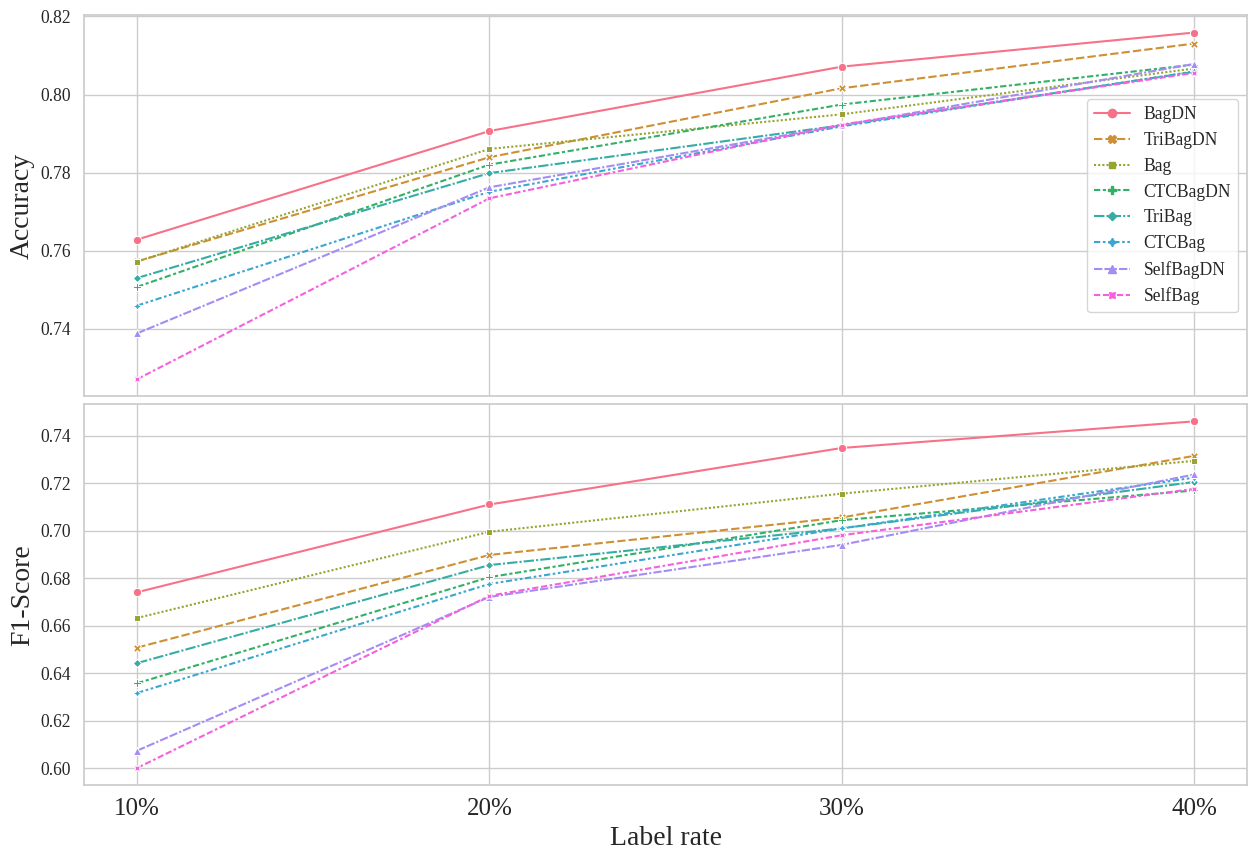

In [83]:
# Plot the means of accuracies and f1 scores, percentaje is the x axis, and the y axis is the mean of accuracies and f1 scores. The hue is the method. Line plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

fig.subplots_adjust(hspace=0.02)

sns.lineplot(data=means_transductive[means_transductive.Metric == "Accuracy"], x="Label rate", y="Value", hue="Method", style="Method", markers=True, ax=ax1)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_xlabel("")
ax1.set_xticklabels(["", "", "", ""])
ax1.legend(loc='right', bbox_to_anchor=(1, 0.5))

# plt.savefig("transductive_accuracy.pdf", bbox_inches="tight")

# fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(data=means_transductive[means_transductive.Metric == "F1"], x="Label rate", y="Value", hue="Method", style="Method", markers=True, ax=ax2)
ax2.set_ylabel("F1-Score", fontsize=20)
ax2.set_xlabel("Label rate", fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18)
ax2.get_legend().remove()


plt.savefig("transductive_metrics.pdf", bbox_inches="tight")

# Plot the means of accuracies and f1 scores, percentaje is the x axis, and the y axis is the mean of accuracies and f1 scores. The hue is the method. Line plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

fig.subplots_adjust(hspace=0.02)

sns.lineplot(data=means_inductive[means_inductive.Metric == "Accuracy"], x="Label rate", y="Value", hue="Method", style="Method", markers=True, ax=ax1)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_xlabel("")
ax1.set_xticklabels(["", "", "", ""])
ax1.legend(loc='right', bbox_to_anchor=(1, 0.5))


# plt.savefig("inductive_accuracy.pdf", bbox_inches="tight")

# fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(data=means_inductive[means_inductive.Metric == "F1"], x="Label rate", y="Value", hue="Method", style="Method", markers=True, ax=ax2)
ax2.set_ylabel("F1-Score", fontsize=20)
ax2.set_xlabel("Label rate", fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=18)
# Remove legend
ax2.get_legend().remove()


plt.savefig("inductive_metrics.pdf", bbox_inches="tight")

In [66]:
# Plot in lineplot the differences between the methods and their DN version

# Create a dataframe with the differences
means_transductive_diff = pd.DataFrame(columns=["Metric", "Value", "Method", "Label rate"])
means_inductive_diff = pd.DataFrame(columns=["Metric", "Value", "Method", "Label rate"])

for (label_rate, metric) in means_trans.columns:
    if metric == "F1":
        continue
    for method in means_trans.index:
        # Ignore if DN
        if "DN" not in method:
            continue
        # Difference
        value_dn_trans = - means_trans[(label_rate, metric)][method[0:-2]] + means_trans[(label_rate, metric)][method]
        value_dn_ind = - means_ind[(label_rate, metric)][method[0:-2]] + means_ind[(label_rate, metric)][method]
        # Append
        means_transductive_diff.loc[len(means_transductive_diff)] = {"Metric": metric, "Value": value_dn_trans, "Method": f"{method} - {method[0:-2]}", "Label rate": label_rate}
        means_inductive_diff.loc[len(means_inductive_diff)] = {"Metric": metric, "Value": value_dn_ind, "Method": f"{method} - {method[0:-2]}", "Label rate": label_rate}

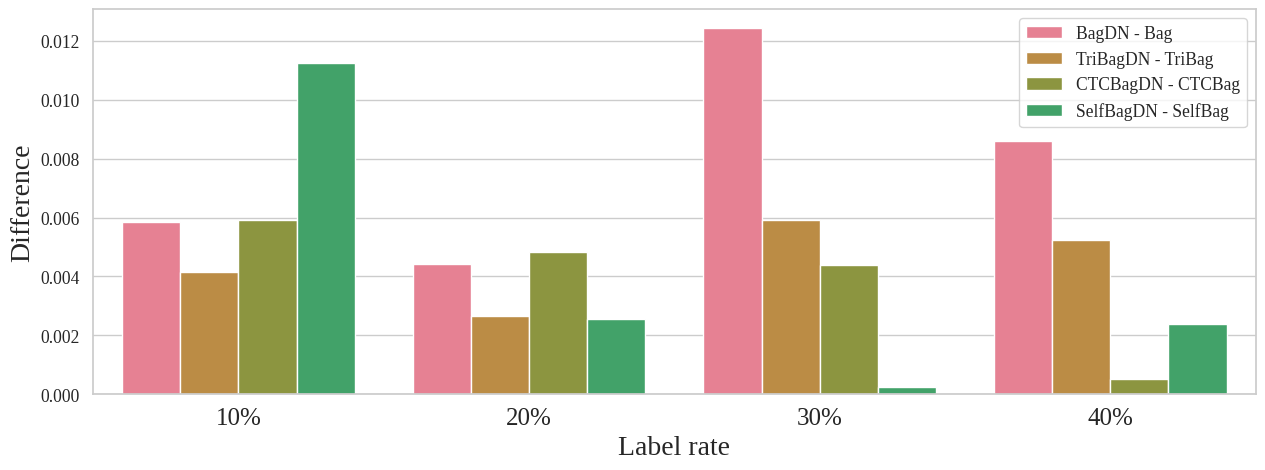

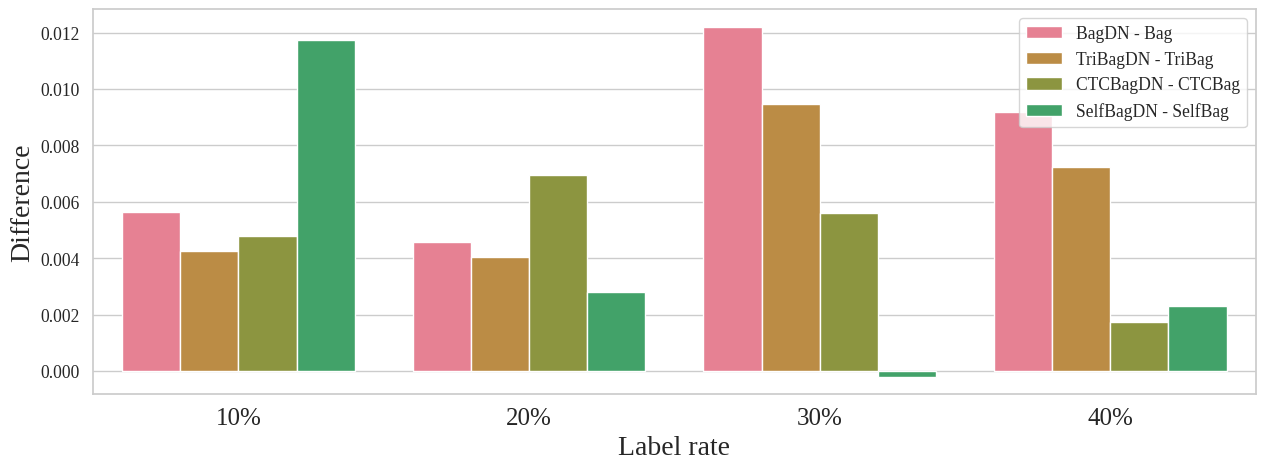

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(data=means_transductive_diff, x="Label rate", y="Value", hue="Method", ax=ax)
ax.set_ylabel("Difference", fontsize=20)
ax.set_xlabel("Label rate", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
plt.legend(title=None)
plt.savefig("transductive_difference_accuracy.pdf", bbox_inches="tight")
# Remove legend title

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(data=means_inductive_diff, x="Label rate", y="Value", hue="Method", ax=ax)
ax.set_ylabel("Difference", fontsize=20)
ax.set_xlabel("Label rate", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
plt.legend(title=None)
plt.savefig("inductive_difference_accuracy.pdf", bbox_inches="tight")